<a href="https://colab.research.google.com/github/calamistratus/Whales_project/blob/main/Picture_augmentation_for_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import os

from tqdm import tqdm
from torchvision import transforms

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
path = ''

train_array = torch.Tensor(np.load(path + 'train_array.npy'))
test_array = torch.Tensor(np.load(path + 'test_array.npy'))

train_length, test_length = train_array.shape[0], test_array.shape[0]
h, w = 100, 200

df = pd.read_csv(path + 'train.csv')

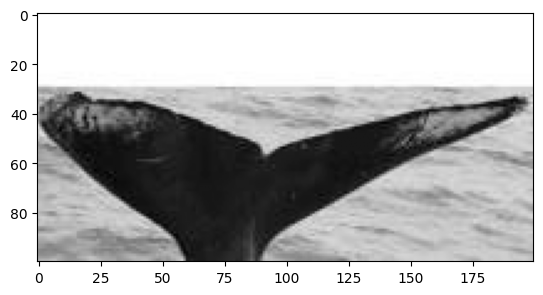

In [ ]:
sample_picture = train_array[2].reshape(h, w).view(1, h, w)

plt.imshow(sample_picture[0], cmap='gray')
plt.show()

# Transforms creation

I have tried making transforms which do not mess with the colours, but rather imitate shape and perpective changes seen in original pictures
They may seem quite brutal, but so is the original dataset



Aggr 0: Simple manipulations to feed the picture into the model

Aggr 1: Simple flips and rotation

Aggr 2: Filters and perspective applied to picture

Aggr 3: Random crop added

In [ ]:
def transforms_constructor(prob, aggr, normalization=None, inverse=True, to_image=False):
  return transforms.Compose([
    transforms.ToPILImage(),

    *[i for i in
      (transforms.RandomCrop(100),
      transforms.Resize((100, 200))) if aggr > 2],

    *[i for i in
      (transforms.Pad(10 * aggr),
      transforms.RandomHorizontalFlip(p = prob),
      transforms.RandomRotation(degrees=(-30 * aggr, 30 * aggr))) if aggr > 0],

    *[i for i in
      (transforms.RandomPerspective(.1 * aggr),
        transforms.RandomAutocontrast(p=prob),
        transforms.RandomAdjustSharpness(.5, p=prob),
        transforms.RandomPosterize(4, p=prob),
        transforms.RandomPosterize(2, p=prob/2)) if aggr > 1],

    transforms.Resize((100, 200)),
    transforms.ToTensor(),

    *[transforms.Normalize(normalization) for _ in [1] if normalization],
    *[transforms.Lambda(lambda x: 1 - x) for _ in [1] if inverse],
    *[transforms.ToPILImage() for _ in [1] if to_image]
])

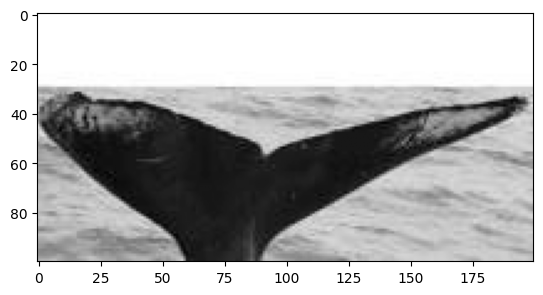

Aggr: 0 Shape: torch.Size([1, 100, 200])


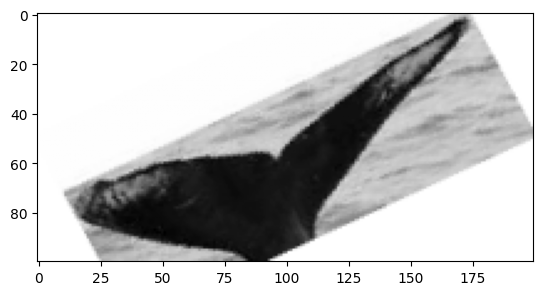

Aggr: 1 Shape: torch.Size([1, 100, 200])


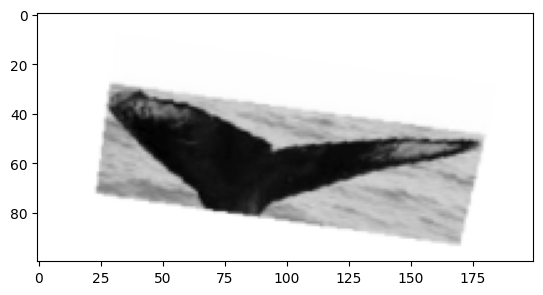

Aggr: 2 Shape: torch.Size([1, 100, 200])


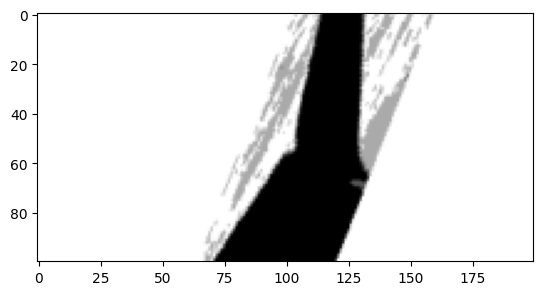

Aggr: 3 Shape: torch.Size([1, 100, 200])


In [ ]:
for i in range(4):
  transforms_custom = transforms_constructor(.5, i)
  pic = transforms_custom(sample_picture)
  plt.imshow(pic[0], cmap='gray')
  plt.show()
  print("Aggr:", i, "Shape:", pic.shape)

# Actual Augmentation

Due to the structure of provided data, Using a dataloader seemed a little bit overboard in structure and lacking in class balance, so I opted for a more interesting approach of counting the frequency of a whale pic and then creating enough modified copies of them with increasing randomness chance to compensate the original lackluster data

In [ ]:
df['Id'].value_counts().drop('new_whale')

Id
w_1287fbc    34
w_98baff9    27
w_7554f44    26
w_1eafe46    23
w_fd1cb9d    22
             ..
w_6f504c0     1
w_2fdee7b     1
w_a0838d1     1
w_3698eaf     1
w_b9bfd4e     1
Name: count, Length: 4250, dtype: int64

<Axes: xlabel='count', ylabel='Count'>

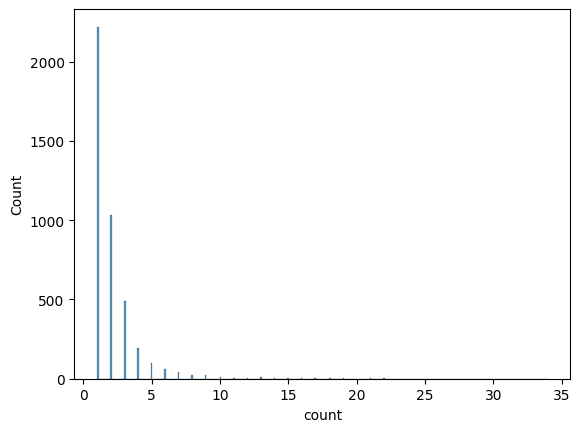

In [ ]:
sns.histplot(df['Id'].value_counts().drop('new_whale'))

In [ ]:
pics_per_class = 100
quality = 95
augmentation_stages = 3
basic_probability = .5
file_format = '.jpg'

os.makedirs(os.path.join(path, 'whales'), exist_ok=True)

for whale in tqdm(df['Id'].value_counts().keys()):
    whale_folder_path = os.path.join(path, 'whales', whale)

    if os.path.isdir(whale_folder_path):
      for pic in os.listdir(whale_folder_path):
          try:
              os.remove(os.path.join(whale_folder_path, pic))

          except PermissionError as e:
              print('Could not delete file at', whale_folder_path, e)
    else:
      os.mkdir(whale_folder_path)

    indexes = df[df['Id'] == whale].index
    amount_pics = len(indexes)
    pics_to_create = np.clip(pics_per_class - amount_pics, 0, pics_per_class)

    basic_transforms = transforms_constructor(prob = basic_probability, aggr=0, to_image=True)
    given_pictures = train_array[indexes].view(amount_pics, h, w)

    for picture, index in zip(given_pictures, indexes):   # Saving regularized pictures already given
        subpath = os.path.join(whale_folder_path, str(index) + file_format)

        basic_transforms(picture).save(subpath, quality = quality)

    if pics_to_create > 0:    # Creation of additional pictures in three stages of augmentation (aggression of it)
        for aggr in range(1, augmentation_stages + 1):
            new_transforms = transforms_constructor(prob = basic_probability, aggr=aggr, to_image=True)

            for j in range(pics_to_create // augmentation_stages):
                choise = given_pictures[np.random.randint(amount_pics)]
                subpath = os.path.join(whale_folder_path, f'aug_{aggr}_{j}' + file_format)

                new_transforms(choise).save(subpath, quality = quality)

        new_transforms = transforms_constructor(prob = basic_probability, aggr=augmentation_stages, to_image=True)

        for i in range(pics_to_create - (pics_to_create // augmentation_stages) * augmentation_stages):   # Handle residue pictures if the amount is not devisible by {augmentation_stages}
            choise = given_pictures[np.random.randint(amount_pics)]
            subpath = os.path.join(whale_folder_path, f'aug_{augmentation_stages}_r_{i}' + file_format)

            new_transforms(choise).save(subpath, quality = quality)

# The result

The folder contains 100 pictures for each class, except 'new_whale', where it has 810 images. Later I might either reduce or increase the number of pictures per class, which can be easly done changing one value in the block above.


Whilst doing so might be memory-heavy, it allows me to make custom augmentations for different images per class, doing the same on the go would actually be harder and less intuitive.